In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

data = load_boston()
data.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [2]:
data["feature_names"]

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [3]:
X, y = data["data"], data["target"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = pd.DataFrame(X_train,columns=data["feature_names"])
X_test = pd.DataFrame(X_test,columns=data["feature_names"])
y_train = pd.DataFrame(y_train,columns=["target"])
y_test = pd.DataFrame(y_test,columns=["target"])

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate

poly_feat_2 = PolynomialFeatures(degree=2) # take this up to 3 and see what happens
X_train_poly = poly_feat_2.fit_transform(X_train)
X_test_poly = poly_feat_2.transform(X_test)

# default parameters of LinearRegression are the same for Lasso
cv_res = []
names = ["Linear regression", "Lasso regression", "Ridge regression", "ElasticNet regression"]
for model in [LinearRegression(),Lasso(),Ridge(),ElasticNet(l1_ratio=0)]:
    cv_res.append(cross_validate(model,
                                X_train_poly,
                                y_train,
                                cv = 5,# we will keep it at 5, since that gives each sample set around 80 samples
                                return_train_score = True,
                                return_estimator = True,
                                n_jobs = 2))

Linear regression, num non-zero weights: 105.0
Lasso regression, num non-zero weights: 55.4
Ridge regression, num non-zero weights: 104.0
ElasticNet regression, num non-zero weights: 104.0


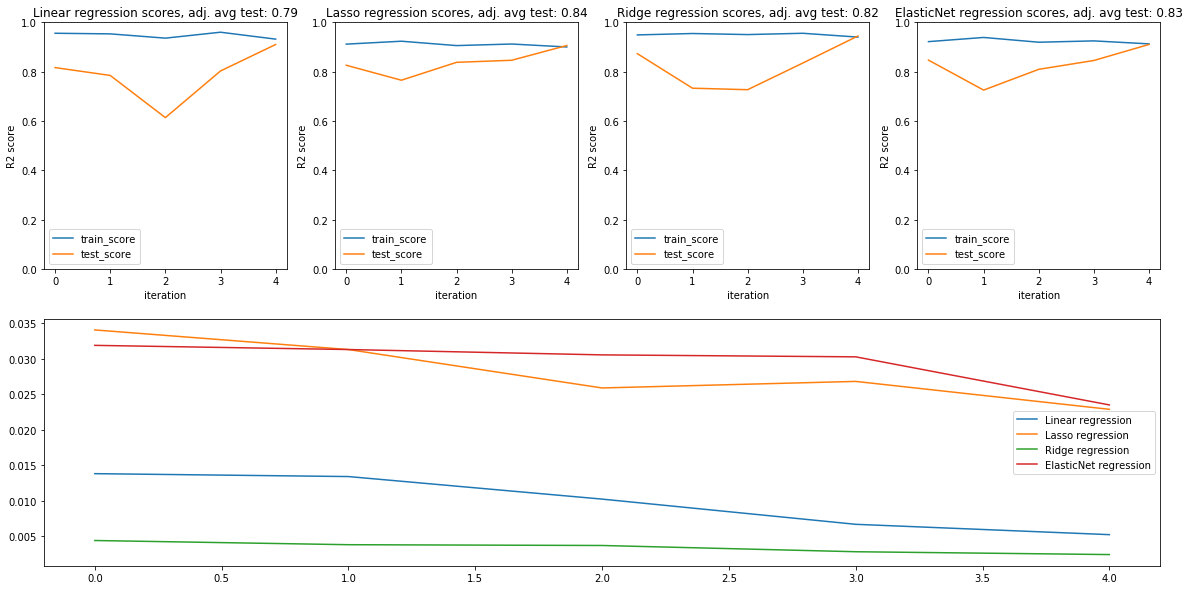

In [6]:
def getNonZeroWeights(est):
    return len(est.coef_[est.coef_!=0])

fig = plt.figure(figsize=(20,10))
trainin_time_ax = fig.add_subplot(2,1,2)
for i in range(4):
    name = names[i]
    df_reg = pd.DataFrame(cv_res[i])
    df_reg["nonZeroWeights"] = df_reg["estimator"].apply(getNonZeroWeights)

    ax = fig.add_subplot(2,4,i+1)

    ax.set_title(name + " scores, adj. avg test: " + \
                 str(round(df_reg.loc[df_reg["test_score"]>0]["test_score"].mean(),2)))
    ax.set_xlabel("iteration")
    ax.set_ylabel("R2 score")
    ax.set_ylim(0,1)
    df_reg[["train_score","test_score"]].plot(ax=ax)
    print(name + ", num non-zero weights:",df_reg["nonZeroWeights"].mean())
    
    df_reg["fit_time"].plot(ax=trainin_time_ax,label=name)

plt.sca(trainin_time_ax)
plt.legend()
plt.show()

# Lasso Regression shows much more consistent performance

# Lasso takes a little "longer" to train, but we can see that differences likely arises due to coordinate descent
# used by Lasso, since when we use L2 regularization using ElasticNet (which uses coordinate descent), we also get
# higher fit times